# Project 2 report

In [1]:
# Imports
import numpy as np
import pandas as pd
import folium
# import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
# import plotly
# from ipywidgets import interact, interactive
# from iPython.display import display
# import descartes

# Params
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

# Q0: Basic EDA + Tidying

In [2]:
# Read in data
df = pd.read_csv('dft_rawcount_region_id_3.csv', low_memory=False)

In [3]:
df.head()

count_point_id direction_of_travel  year  count_date  hour  region_id  \
0          931907                   N  2019  2019-06-17    18          3   
1          931907                   S  2019  2019-06-17    13          3   
2          931907                   N  2019  2019-06-17     9          3   
3          931907                   S  2019  2019-06-17    12          3   
4          931907                   S  2019  2019-06-17    10          3   

  region_name  local_authority_id local_authority_name road_name road_type  \
0    Scotland                  29    City of Edinburgh         U     Minor   
1    Scotland                  29    City of Edinburgh         U     Minor   
2    Scotland                  29    City of Edinburgh         U     Minor   
3    Scotland                  29    City of Edinburgh         U     Minor   
4    Scotland                  29    City of Edinburgh         U     Minor   

  start_junction_road_name end_junction_road_name  easting  northing  \
0                      NaN                    NaN   318480    675750   
1                      NaN                    NaN   318480    675750   
2                      NaN                    NaN   318480    675750   
3                      NaN                    NaN   318480    675750   
4                      NaN                    NaN   318480    675750   

    latitude  longitude  link_length_km  link_length_miles  pedal_cycles  \
0  55.967806   -3.30758             NaN                NaN             8   
1  55.967806   -3.30758             NaN                NaN             1   
2  55.967806   -3.30758             NaN                NaN             5   
3  55.967806   -3.30758             NaN                NaN             2   
4  55.967806   -3.30758             NaN                NaN             4   

   two_wheeled_motor_vehicles  cars_and_taxis  buses_and_coaches  lgvs  \
0                           2             290                  5    20   
1                           1             258                  4    36   
2                           1             270                  5    44   
3                           2             266                  4    50   
4                           0             247                  8    35   

   hgvs_2_rigid_axle  hgvs_3_rigid_axle  hgvs_3_or_4_articulated_axle  \
0                  0                  0                             0   
1                  4                  2                             0   
2                  5                  2                             0   
3                  2                  5                             0   
4                  2                  3                             0   

   hgvs_4_or_more_rigid_axle  hgvs_5_articulated_axle  \
0                          0                        0   
1                          1                        0   
2                          1                        0   
3                          2                        0   
4                          3                        0   

   hgvs_6_articulated_axle  all_hgvs  all_motor_vehicles  
0                        0         0                 317  
1                        0         7                 306  
2                        0         8                 328  
3                        0         9                 331  
4                        0         8                 298

In [ ]:
df.describe(include='all')

### Removing unnecessary columns

In [4]:
df_tidy = df.copy() # Tidy dataset storage

# Cols to drop
rm_cols = ['region_id', 'region_name', 'local_authority_id', 'road_type',
           'start_junction_road_name', 'end_junction_road_name',
           'year', 'easting', 'northing', 'link_length_miles', 'hgvs_2_rigid_axle',
           'hgvs_3_rigid_axle', 'hgvs_3_or_4_articulated_axle',
           'hgvs_4_or_more_rigid_axle', 'hgvs_5_articulated_axle',
           'hgvs_6_articulated_axle']

# Drop cols
df_tidy.drop(rm_cols, axis=1, inplace=True)

### Renaming Vehicle Labels 

In [5]:
new_names = ['bikes', 'motorcycles', 'cars', 'buses', 'lgvs', 'hgvs'] # More interpretable labels
name_mappings = dict(zip(df_tidy.columns[9:-1], new_names)) # Creating dict of label mappings
df_tidy.rename(columns=name_mappings, inplace=True) # Renaming columns

### Tidy Transformations

In [6]:
# all_motor_vehicles --> all_vehicles (include bikes)
df_tidy['all_vehicles'] = df_tidy['bikes'] + df_tidy['motorcycles'] + df_tidy['cars'] + df_tidy['buses'] + \
                          df_tidy['lgvs'] + df_tidy['hgvs']

# New column for specifying whether road is: M, A, B, C, U
df_tidy = df_tidy.assign(
            road_type = lambda dataframe: dataframe['road_name'].map(lambda road_name: road_name[0]))

# Convert count_date to datetime format
df_tidy['count_date'] = pd.to_datetime(df['count_date'], format='%Y-%m-%d')

In [ ]:
df_tidy.head(1000)

### Adding Population Data

In [7]:
# Read in population statistics
pop_df = pd.read_csv('scotland-mid-year-pop-est-19.csv', header=None)

# Rename columns
pop_df.rename(columns={0: 'local_authority_name', 1: 'population'}, inplace=True)

# Convert population to int
pop_df.population = pop_df.population.str.replace(',', '')
pop_df.population = pop_df.population.astype('int') 

# String replaces to avoid join issues
pop_df.local_authority_name = pop_df.local_authority_name.str.replace('Na h-Eileanan Siar', 'Eilean Siar')
#pop_df.sort_values(by='local_authority_name', axis=0, inplace=True, ascending=True)
df_tidy.local_authority_name = df_tidy.local_authority_name.str.replace('Comhairle nan Eilean Siar', 'Eilean Siar')
df_tidy.local_authority_name = df_tidy.local_authority_name.str.replace('&', 'and')

# Overwrite df_tidy with full outer join with population data`
df_tidy = pd.merge(df_tidy, pop_df, on='local_authority_name', how='outer')

In [8]:
pop_df

local_authority_name  population
0           Aberdeen City      228670
1           Aberdeenshire      261210
2                   Angus      116200
3         Argyll and Bute       85870
4       City of Edinburgh      524930
5        Clackmannanshire       51540
6   Dumfries and Galloway      148860
7             Dundee City      149320
8           East Ayrshire      122010
9     East Dunbartonshire      108640
10           East Lothian      107090
11      East Renfrewshire       95530
12                Falkirk      160890
13                   Fife      373550
14           Glasgow City      633120
15               Highland      235830
16             Inverclyde       77800
17             Midlothian       92460
18                  Moray       95820
19            Eilean Siar       26720
20         North Ayrshire      134740
21      North Lanarkshire      341370
22         Orkney Islands       22270
23      Perth and Kinross      151950
24           Renfrewshire      179100
25       Scottish Borders      115510
26       Shetland Islands       22920
27         South Ayrshire      112610
28      South Lanarkshire      320530
29               Stirling       94210
30    West Dunbartonshire       88930
31           West Lothian      183100

# Q1: Bar chart of [X] longest roads showing start and end locations

### Method
* Filter by distinguishing road name 
* Ignore U and C roads 
* We have start and end junctions (general locations)
* How do we calculate distance?
    1. Add up link lengths
    2. Verify with Google Maps



# Q2: Local authorities managing number of roads - mapviz - fixed point in time

### Outcome
* 2019 map of roads managed
* Static map of Scotland with gradient colour scheme

### Method
* Group by `local_authority_name`, `count_id`
* Break down total number of roads per authority into `road_names`
* Possible weight matrix to give larger, busier roads a larger influence in the map - don't want to give U and C thes same weighting as M and A roads
* In `road_name` variable, cut string such that it's only a single character

### Stretch and Challenge
* Maintenance data to observe which authority spends the most on maintainance

### Extra Packages:
* folium
* geopandas

In [9]:
map_cols = ['count_point_id', 'local_authority_name', 'count_date', 'road_name', 'hour', 'direction_of_travel', 'latitude', 'longitude', 'population']
map_df = df_tidy[map_cols]

In [19]:
auth_names = sorted(map_df.local_authority_name.unique())
lat_longs = [[57.148499575046166, -2.0994503154974553],[57.273760025881934, -2.5166643080179645],[56.72768401017168, -2.9246922126651884],[56.09740006583508, -5.505829190157146],[55.95233877595505, -3.188860106840768],[56.14959079238047, -3.7457616021792624],[55.085097679793755, -3.9648777663637222],[56.46547771536677, -2.9702673126999213],[55.465299446108205, -4.307460244966752],[55.950679905225755, -4.21793961543706],[55.943997191276125, -2.7324635644378654],[55.75505725179119, -4.362197202163319],[58.24343874214309, -6.382783267363518],[56.00349190992439, -3.7933138794341983], [56.246895135851844, -3.087199713717091],[55.85890878015006, -4.246879570599694],[57.47148264549703, -4.918077719700579],[55.910241417028985, -4.73843337649973],[55.8380756961132, -3.091164797971764],[57.507658214268204, -3.2238412189671544], [55.72279452380807, -4.743315946865488], [55.87990377885493, -3.943898088843739], [59.02526102084918, -3.006499055095088], [56.55895608244633, -3.8058868668882613], [55.84937262539755, -4.534918906544666], [55.580570268563, -2.726163579854028], [60.33439464263681, -1.2344978915362006], [55.29083618369606, -4.6958972343105625], [55.59988380366663, -3.7749667034686474], [56.22513721244209, -4.338586907406815], [55.982771806368184, -4.5149571176594625], [55.88803749019023, -3.570496063254735]]
coords_dict = dict(zip(auth_names, lat_longs)) 
coords_df = pd.DataFrame.from_dict(coords_dict, orient='index', columns=['cent_lat', 'cent_long'])
coords_df.reset_index(level=0, inplace=True)
coords_df.rename(columns={'index':'local_authority_name'}, inplace=True)
coords_df

local_authority_name   cent_lat  cent_long
0           Aberdeen City  57.148500  -2.099450
1           Aberdeenshire  57.273760  -2.516664
2                   Angus  56.727684  -2.924692
3         Argyll and Bute  56.097400  -5.505829
4       City of Edinburgh  55.952339  -3.188860
5        Clackmannanshire  56.149591  -3.745762
6   Dumfries and Galloway  55.085098  -3.964878
7             Dundee City  56.465478  -2.970267
8           East Ayrshire  55.465299  -4.307460
9     East Dunbartonshire  55.950680  -4.217940
10           East Lothian  55.943997  -2.732464
11      East Renfrewshire  55.755057  -4.362197
12            Eilean Siar  58.243439  -6.382783
13                Falkirk  56.003492  -3.793314
14                   Fife  56.246895  -3.087200
15           Glasgow City  55.858909  -4.246880
16               Highland  57.471483  -4.918078
17             Inverclyde  55.910241  -4.738433
18             Midlothian  55.838076  -3.091165
19                  Moray  57.507658  -3.223841
20         North Ayrshire  55.722795  -4.743316
21      North Lanarkshire  55.879904  -3.943898
22         Orkney Islands  59.025261  -3.006499
23      Perth and Kinross  56.558956  -3.805887
24           Renfrewshire  55.849373  -4.534919
25       Scottish Borders  55.580570  -2.726164
26       Shetland Islands  60.334395  -1.234498
27         South Ayrshire  55.290836  -4.695897
28      South Lanarkshire  55.599884  -3.774967
29               Stirling  56.225137  -4.338587
30    West Dunbartonshire  55.982772  -4.514957
31           West Lothian  55.888037  -3.570496

In [11]:
# Can use the mean of the lat and longs in df_tidy
# More robust if we swapped out map
coords_df_tidy = df_tidy[['local_authority_name', 'latitude', 'longitude']]
coords_df_tidy = coords_df_tidy.groupby('local_authority_name')[['latitude', 'longitude']].mean()
coords_df_tidy.rename(columns={'latitude':'cent_lat', 'longitude':'cent_long'}, inplace=True) # Renaming columns
coords_df_tidy.reset_index(level = 0, inplace = True)

In [12]:
coords_df_tidy

local_authority_name   cent_lat  cent_long
0           Aberdeen City  57.150242  -2.135338
1           Aberdeenshire  57.328134  -2.392169
2                   Angus  56.640738  -2.772170
3         Argyll and Bute  56.050036  -5.259660
4       City of Edinburgh  55.944230  -3.217799
5        Clackmannanshire  56.136319  -3.752152
6   Dumfries and Galloway  55.028961  -3.824282
7             Dundee City  56.457037  -2.966936
8           East Ayrshire  55.580959  -4.420528
9     East Dunbartonshire  55.941432  -4.210586
10           East Lothian  55.955855  -2.830035
11      East Renfrewshire  55.781528  -4.344350
12            Eilean Siar  58.011596  -6.662198
13                Falkirk  56.004994  -3.798059
14                   Fife  56.179792  -3.161934
15           Glasgow City  55.865811  -4.249760
16               Highland  57.565275  -4.457772
17             Inverclyde  55.933102  -4.746981
18             Midlothian  55.883706  -3.087176
19                  Moray  57.562817  -3.224110
20         North Ayrshire  55.684088  -4.810325
21      North Lanarkshire  55.866559  -3.988987
22         Orkney Islands  58.994666  -3.053560
23      Perth and Kinross  56.431372  -3.596514
24           Renfrewshire  55.861975  -4.458042
25       Scottish Borders  55.614229  -2.628423
26       Shetland Islands  60.257076  -1.252042
27         South Ayrshire  55.426621  -4.652417
28      South Lanarkshire  55.728597  -3.986469
29               Stirling  56.138214  -4.102589
30    West Dunbartonshire  55.940983  -4.490829
31           West Lothian  55.907175  -3.579643

In [ ]:
map_df = pd.merge(map_df, coords_df, on='local_authority_name', how='outer')

In [ ]:
map_df

In [13]:
auth_geo = os.path.join(os.getcwd(), 'local_auth.json')
with open(auth_geo) as f:
    scotland_topo = json.load(f)

topo_names = []
for i in range(32):
    topo_names.append(scotland_topo['objects']['lad']['geometries'][i]['properties']['LAD13NM'])

In [87]:
# Reference: https://towardsdatascience.com/choropleth-maps-with-folium-1a5b8bcdd392

# Initialise map of Scotland
scotland_dark = folium.Map(location=[57.8906712, -4.2026458], zoom_start=6.25, tiles='cartodbdark_matter')

#Try a different style?
scotland_stamen = folium.Map(location=[57.8906712, -4.2026458], zoom_start=6.25, tiles='stamenwatercolor')


# Add tiles to different style map
#tiles = ['stamenwatercolor','cartodbpositron','openstreetmap','stamenterrain']
#for tile in tiles:
#   folium.TileLayer(tile).add_to(scotland_stamen)

In [88]:
# Create choloropleth of population data

choropleth = folium.Choropleth(geo_data = scotland_topo,                  #json
    topojson = 'objects.lad',
    key_on ='feature.properties.LAD13NM',
    data = map_df,
    columns = ['local_authority_name', 'population'], 
    name ='choropleth',                                   
    fill_color ='YlGnBu', 
    fill_opacity = 1, # Prev 0.7
    line_opacity = 0.5, # Prev 0.2
    highlight = True,
    legend_name='Population',
    smooth_factor=0,
).add_to(scotland_dark) # Prev scotland

# Add labels indicating local authority name
style_function = "font-size: 12px"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['LAD13NM'], style=style_function, labels=False))

# Add layer control
folium.LayerControl().add_to(scotland_dark)

In [89]:
scotland_dark

In [17]:
pop_viz_df = pd.merge(pop_df, coords_df_tidy, on='local_authority_name', how='outer')
pop_viz_df

local_authority_name  population   cent_lat  cent_long
0           Aberdeen City      228670  57.150242  -2.135338
1           Aberdeenshire      261210  57.328134  -2.392169
2                   Angus      116200  56.640738  -2.772170
3         Argyll and Bute       85870  56.050036  -5.259660
4       City of Edinburgh      524930  55.944230  -3.217799
5        Clackmannanshire       51540  56.136319  -3.752152
6   Dumfries and Galloway      148860  55.028961  -3.824282
7             Dundee City      149320  56.457037  -2.966936
8           East Ayrshire      122010  55.580959  -4.420528
9     East Dunbartonshire      108640  55.941432  -4.210586
10           East Lothian      107090  55.955855  -2.830035
11      East Renfrewshire       95530  55.781528  -4.344350
12                Falkirk      160890  56.004994  -3.798059
13                   Fife      373550  56.179792  -3.161934
14           Glasgow City      633120  55.865811  -4.249760
15               Highland      235830  57.565275  -4.457772
16             Inverclyde       77800  55.933102  -4.746981
17             Midlothian       92460  55.883706  -3.087176
18                  Moray       95820  57.562817  -3.224110
19            Eilean Siar       26720  58.011596  -6.662198
20         North Ayrshire      134740  55.684088  -4.810325
21      North Lanarkshire      341370  55.866559  -3.988987
22         Orkney Islands       22270  58.994666  -3.053560
23      Perth and Kinross      151950  56.431372  -3.596514
24           Renfrewshire      179100  55.861975  -4.458042
25       Scottish Borders      115510  55.614229  -2.628423
26       Shetland Islands       22920  60.257076  -1.252042
27         South Ayrshire      112610  55.426621  -4.652417
28      South Lanarkshire      320530  55.728597  -3.986469
29               Stirling       94210  56.138214  -4.102589
30    West Dunbartonshire       88930  55.940983  -4.490829
31           West Lothian      183100  55.907175  -3.579643

In [85]:
for auth_name in auth_names:
    folium.Circle(
        location = [pop_viz_df.loc[pop_viz_df['local_authority_name'] == auth_name]['cent_lat'].values[0], 
                pop_viz_df.loc[pop_viz_df['local_authority_name'] == auth_name]['cent_long'].values[0]],
        radius = float(pop_viz_df.loc[pop_viz_df['local_authority_name'] == auth_name]['population'].values[0]/100),
        color = 'orange',
        fill_color="orange",
        popup= f"Population as of 2020: {int(pop_viz_df.loc[pop_viz_df['local_authority_name'] == auth_name]['population'].values[0])}",
        #tooltip = auth_name,
    ).add_to(scotland_dark)

In [86]:
scotland_dark

In [ ]:
pop_df


# Q3: Interactive visualization of the distribution of vehicles over each type of road over the past [X] years

### Outcome
* x-axis: discrete vehicle type data e.g.  cars, bikes, buses, hgvs, lgvs etc
* y-axis: type of road e.g. M, A, B, C, U
* Scatter point for each category where size indicates prevalence of that type of vehicle on that type of road
* Slider which shows variation of data over [X] years


### Method
* Group C and U roads
* Normalize scatter points by \pi*R^2


### Stretch and Challenge
* We have dotted line outline of average of previous 5 years giving the reader some indication of growth/reduction
* x-axis: as emojis


### Extra packages
* plotly - used to vary the datapoints



In [ ]:
df_tidy

# Q4: Time of day viz?

### Outcome
* x-axis: Hours of the day (07:00 - 18:00)
* y-axis-1: `all_vehicles`
* y-axis-2: types of vehicle (faceted plot)
* Light alpha filled densities

### Method
* Get hours day
* Group vehicle count by hour type
* Further subset those counts by vehicle

In [28]:
tod_df = df_tidy[['hour'] + new_names] # Extracting relevant variables
tod_df = tod_df.groupby('hour').sum() # Find total counts of each vehicle at every hour
tod_df.reset_index(level=0, inplace=True)
tod_df = tod_df.melt(id_vars='hour', var_name='vehicle_type') # Pivot longer
tod_df.vehicle_type = tod_df.vehicle_type.astype('category') 

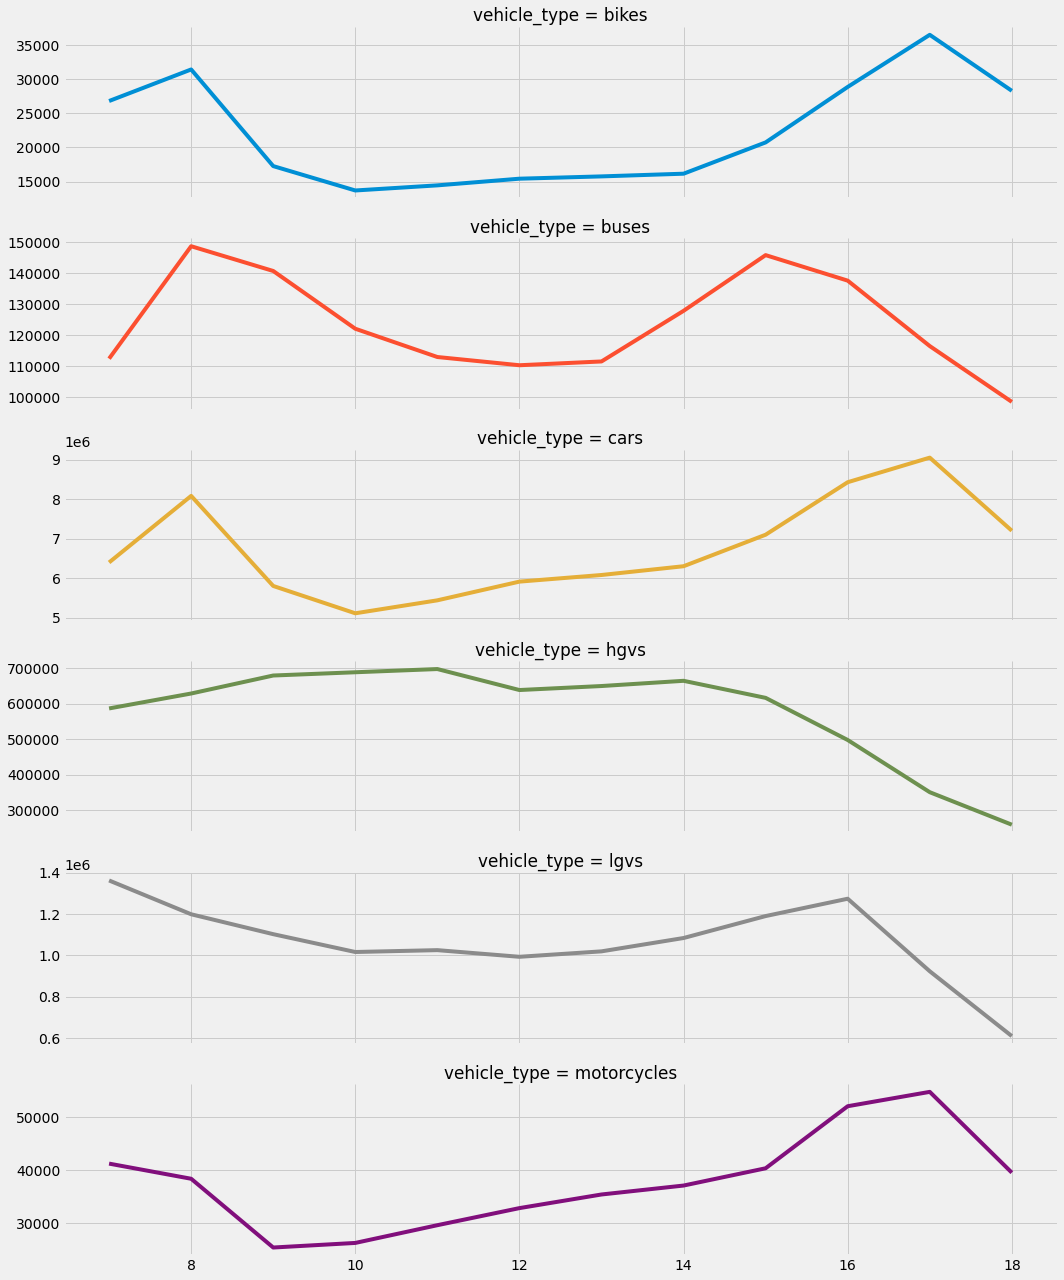

In [29]:
plt.style.use('fivethirtyeight')
g = sns.FacetGrid(data=tod_df, col='vehicle_type', height=3, col_wrap=1, 
                  sharex=True, sharey=False, aspect=5)
g = g.map_dataframe(sns.lineplot, x='hour', y='value', hue ='vehicle_type')

In [30]:
x = tod_df.hour.unique()
y1 = tod_df.loc[tod_df.vehicle_type=='cars']['value']
y2 = tod_df.loc[tod_df.vehicle_type=='lgvs']['value']
y3 = tod_df.loc[tod_df.vehicle_type=='hgvs']['value']
y4 = tod_df.loc[tod_df.vehicle_type=='buses']['value']
y5 = tod_df.loc[tod_df.vehicle_type=='motorcycles']['value']
y6 = tod_df.loc[tod_df.vehicle_type=='bikes']['value']
y = [y1, y2, y3, y4, y5, y6]

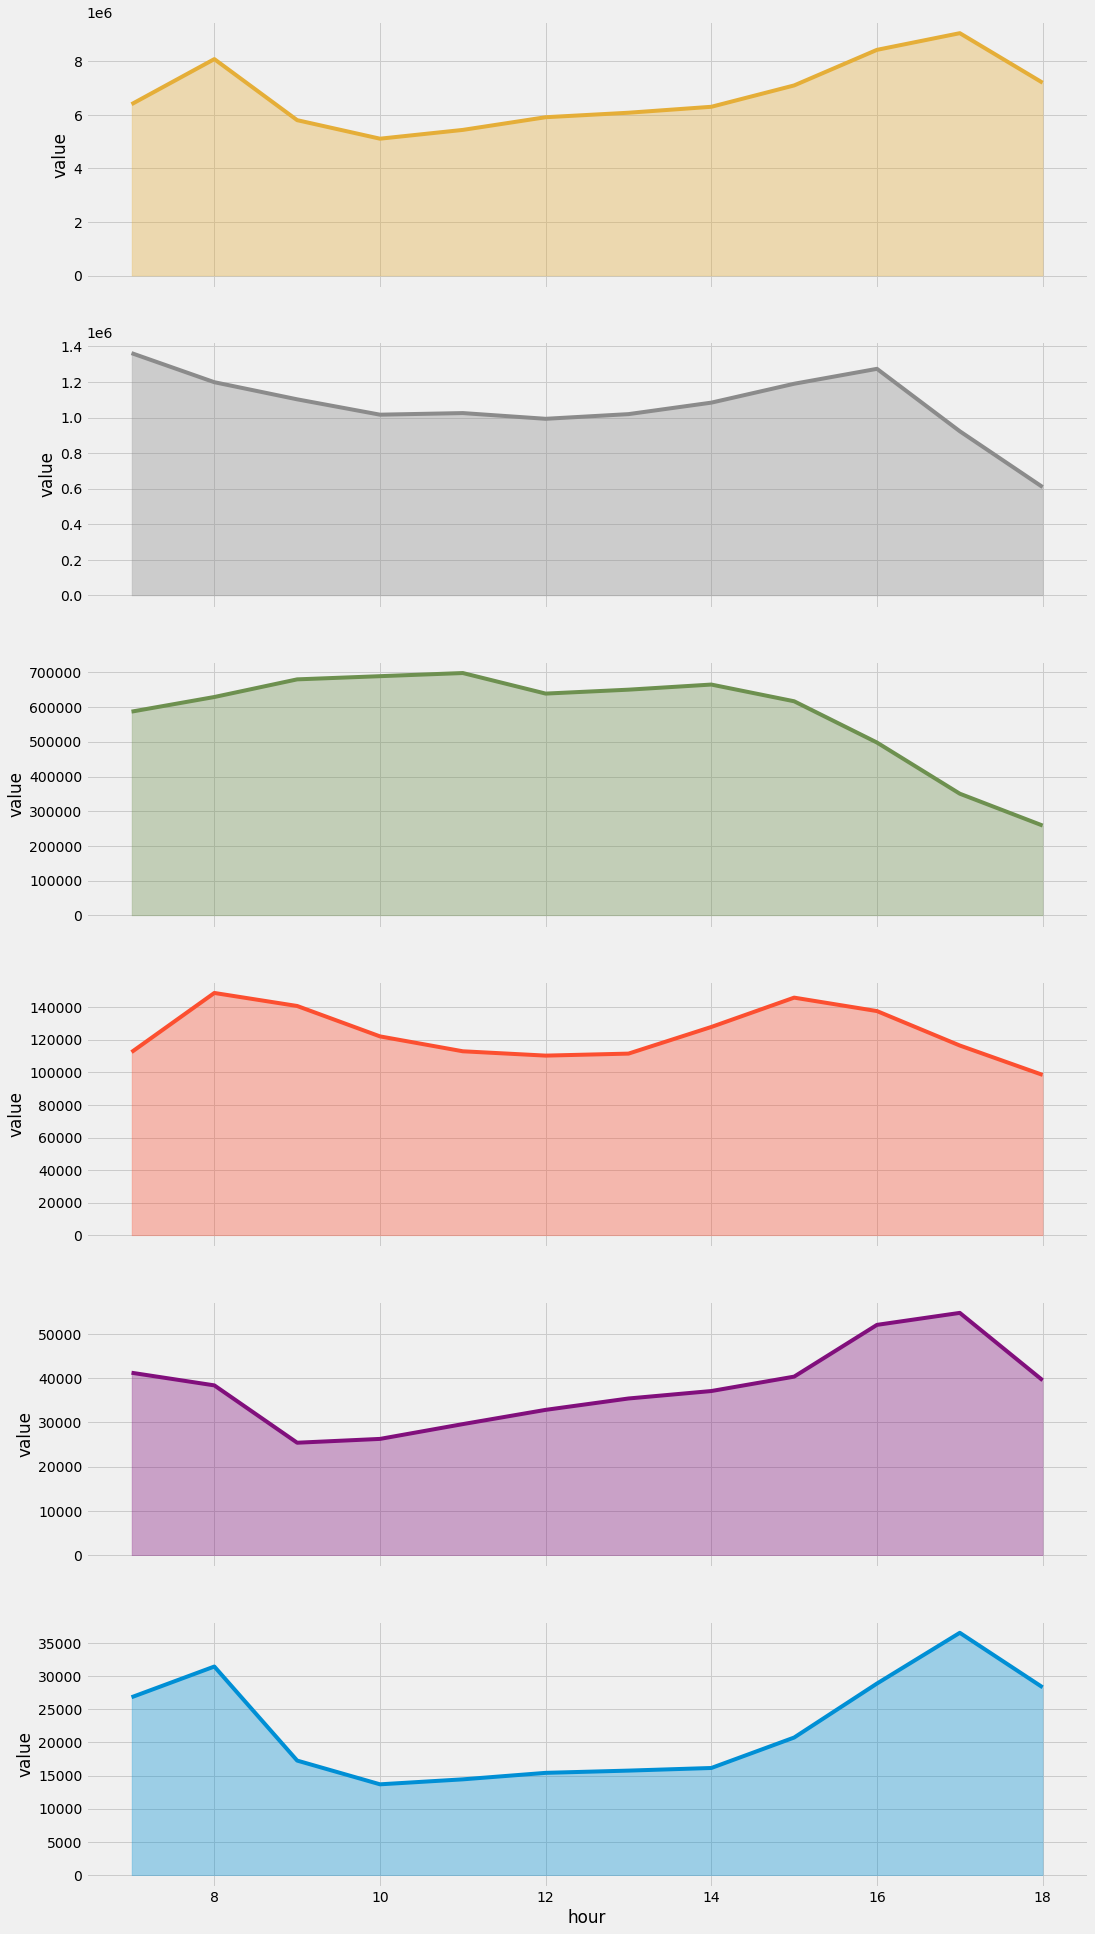

In [31]:
fig, axes = plt.subplots(6, 1, sharex=True, sharey=False, figsize=(16, 32))
hues = ['#e5ae38', '#8b8b8b', '#6d904f', '#fc4f30', '#810f7c', '#008fd5']
for i, ax in enumerate(axes):
    sns.lineplot(data=tod_df, x='hour', y=y[i], ax=ax, hue='vehicle_type')
    ax.fill_between(x, y[i], color=hues[i], alpha=0.35)
    ax.get_legend().remove()

### TODOs for Q4:

* Add all hours to x-axis
* Format y-axis, and change labels
* Add hover on hour points to read values
* Display legend of colour <--> vehicle_type

# Q5: Bikes observed per 10k residents / capita per local authority 

### Caveats
1. Count data of bikes is assumed to be representative of the prevalence of bikes in the authority
2. A bike count within a local authority maps to that bike actually belonging to that authority
3. Double counting effects are ignored

This is because bikes are not registered vehicles and hence this assumption has to be made. We think this is a reasonable assumption since bikes are used for micro-mobility in the majority of cases.

### Outcome
* Horizontal bar chart ordered in descending order

### Method
* Get population data and store in tidy dataframe
* Plot the data

## Additional
* Encode or visualise population data
* Bikes per 10,000 residents - same as log

In [32]:
bikes_cols = ['local_authority_name', 'bikes', 'population']

df_bikes = df_tidy[bikes_cols]

In [37]:
def div_series(df):
    return df['bikes'].sum() * 10000 / float(df['population'].sum())

In [38]:
pop_df

local_authority_name  population
0           Aberdeen City      228670
1           Aberdeenshire      261210
2                   Angus      116200
3         Argyll and Bute       85870
4       City of Edinburgh      524930
5        Clackmannanshire       51540
6   Dumfries and Galloway      148860
7             Dundee City      149320
8           East Ayrshire      122010
9     East Dunbartonshire      108640
10           East Lothian      107090
11      East Renfrewshire       95530
12                Falkirk      160890
13                   Fife      373550
14           Glasgow City      633120
15               Highland      235830
16             Inverclyde       77800
17             Midlothian       92460
18                  Moray       95820
19            Eilean Siar       26720
20         North Ayrshire      134740
21      North Lanarkshire      341370
22         Orkney Islands       22270
23      Perth and Kinross      151950
24           Renfrewshire      179100
25       Scottish Borders      115510
26       Shetland Islands       22920
27         South Ayrshire      112610
28      South Lanarkshire      320530
29               Stirling       94210
30    West Dunbartonshire       88930
31           West Lothian      183100

In [41]:
bikes_per_10k_residents = df_bikes.groupby(['local_authority_name'], as_index=True).apply(div_series).sort_values(ascending=False)

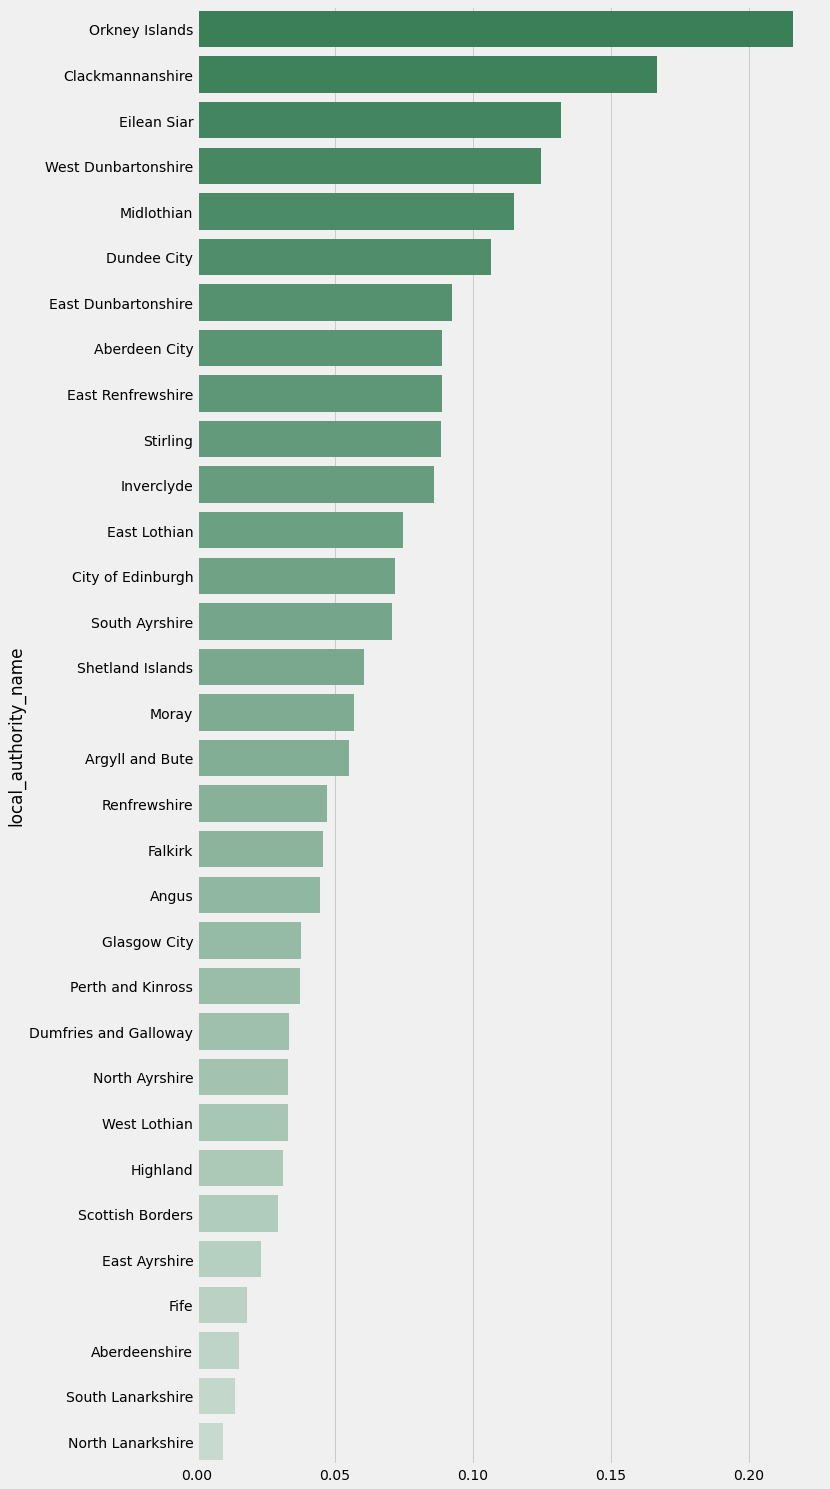

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (10, 25))
pal = sns.light_palette("seagreen", n_colors=40, reverse=True)
sns.barplot(x = bikes_per_capita, y = bikes_per_10k_residents.index, palette=pal)
plt.show()

In [ ]:
# BONUS!

# Create tidy dataframe for bikes only

df_tidy.head()

# Extract: bikes, count_date, hour
bikes_cols = ['count_date', 'hour', 'bikes']
df_bikes = df_tidy[bikes_cols]

# Transform: count_date --> weekday
df_bikes['weekday'] = df_bikes['count_date'].dt.day_name()
df_bikes.groupby(['weekday', 'hour']).sum()

In [ ]:
sns.set_style()